<a href="https://colab.research.google.com/github/ziatdinovmax/APS2020Tutorial/blob/master/APS2020_GPim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gaussian processes for sparse 2D and 3D imaging

Prepared by Maxim Ziatdinov (February 2020)

E-mail: ziatdinovmax@gmail.com

---

This notebook applies Gaussian process regression for reconstructing sparse 2D microscopy scans and 3D hyperspectral data using [GPim](https://github.com/ziatdinovmax/GPim) package (which serves as a high-level wrapper for Gaussian processes in [Pyro](https://pyro.ai/) and [GPyTorch](https://gpytorch.ai/) libraries)

---



In [0]:
#@title Install/Import modules { form-width: "20%" }
# Install GPim
!python3 -m pip install -q git+https://github.com/ziatdinovmax/GPim.git --upgrade
# Imports
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from gpim import skgpr, gpr, gprutils
import torch
# download training data
!wget -qq -O 'spiral_scans_2d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/spiral_s_00010_2019.npy?raw=true'
!wget -qq -O 'sparse_hyper_3d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/bepfm_test_data.npy?raw=true'

## 2D sparse scans

Read and plot sparse 2D image data:

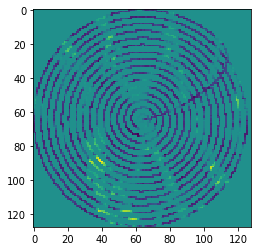

In [0]:
imgdata2d = np.load('spiral_scans_2d.npy')
plt.imshow(imgdata2d);

Normalize and assign NaNs to regions with no data:

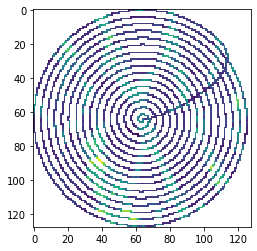

In [0]:
R = (imgdata2d - np.min(imgdata2d)) / np.ptp(imgdata2d)
R[R == R[1, 1]] = np.nan # Take value at [1, 1] as missing data value
plt.imshow(R);

Prepare data for GP regression. We are going to use a sparse grid ```X``` for model training and a full grid ```X_true``` for "testing"/prediction.

In [0]:
X = gprutils.get_sparse_grid(R) # get sparse grid indices
X_true = gprutils.get_grid_indices(R) # get full grid indices

We will now run the GP regression for reconstructing the image from the sparse scan. Notice that by varying parameters such as ```indpoints```, ```learning_rate``` and ```iterations```, you can vary the model training time between seconds and minutes.

**Try** reducing number of inducing points to 200 and number of iterations to 150 and see if the tradeoff between accuracy and speed is acceptable.

# of inducing points for GP regression: 1053
Model training...
average time per iteration: 0.0579 s
training completed in 16.67 s
Final parameter values:
 amp: 0.0493, lengthscale: [3.9108 2.8306], noise: 0.0039265
Calculating predictive mean and variance... Done


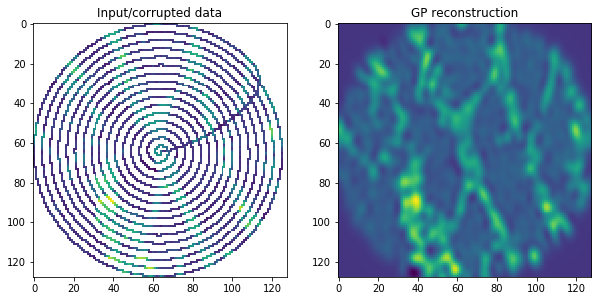

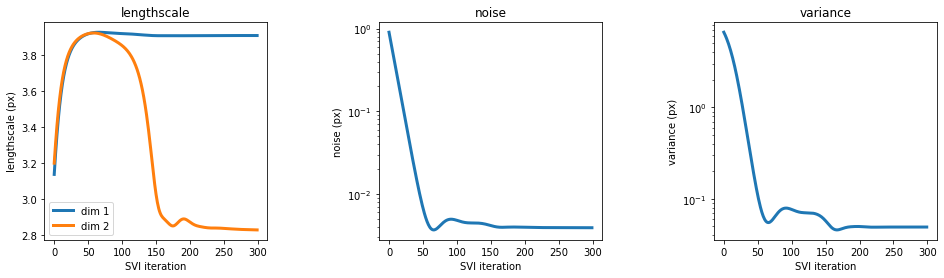

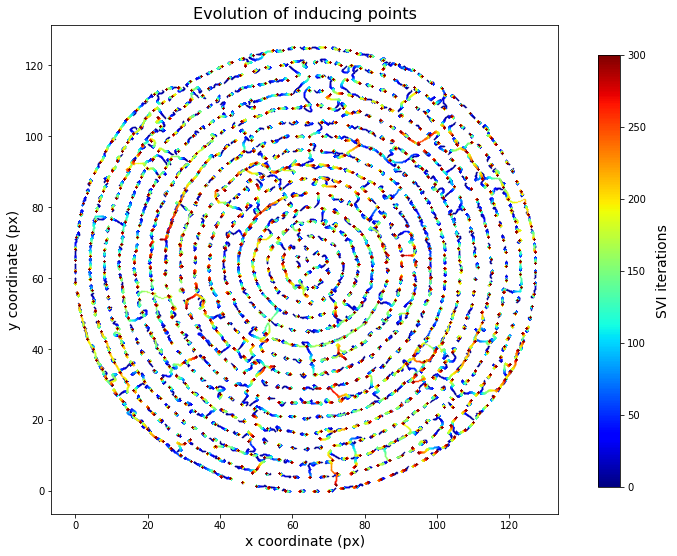

In [0]:
# type of kernel ('RBF', 'Matern52' or 'RationalQuadratic')
kernel = 'RBF'
# lengthscale constraints
lengthscale = [[1., 1.], [4., 4.]]
# Initiate and run GP reconstruction
reconstructor = gpr.reconstructor(
    X, R, X_true, kernel, lengthscale=lengthscale,
    indpoints=1000, learning_rate=0.1, iterations=300, 
    use_gpu=True, verbose=False
)
mean, sd, hyperparams = reconstructor.run()
# Plot results and evolution of kernel hyperparameters during training
gprutils.plot_reconstructed_data2d(R, mean, cmap='viridis')
gprutils.plot_kernel_hyperparams(hyperparams)
gprutils.plot_inducing_points(hyperparams)

We can also try [structured kernel](http://proceedings.mlr.press/v37/wilson15.pdf) GP approach using the GPyTorch implementation under the hood. Here you can also try reducing number of iterations (say, to 50) as well as grid_points_ratio(say, to 0.25) and see whether a trade-off between accuracy and speed is acceptable.

Model training...
average time per iteration: 0.305 s
training completed in 51.56 s
Final parameter values:
 lengthscale: [2.7024 2.7024], noise: 0.0024733
Calculating predictive mean and uncertainty...
Batch 1/1
Done


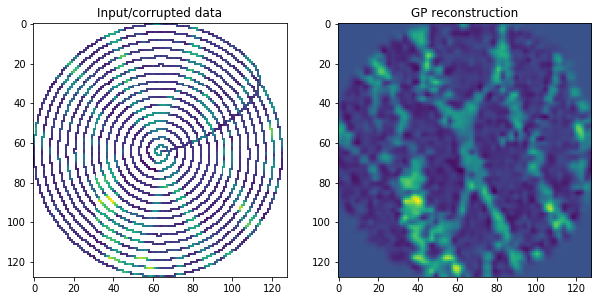

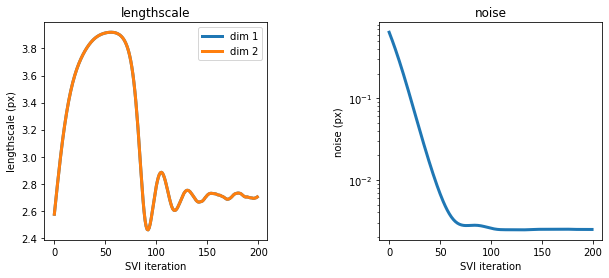

In [0]:
# Initiate and run GP reconstruction
skreconstructor = skgpr.skreconstructor(
    X, R, X_true, kernel, lengthscale=lengthscale,
    grid_points_ratio=1., learning_rate=0.1, 
    iterations=200, calculate_sd=True, num_batches=1,
    use_gpu=True, verbose=False
)
(mean, sd), hyperparams = skreconstructor.run()
# Plot results and evolution of kernel hyperparameters during training
gprutils.plot_reconstructed_data2d(R, mean, cmap='viridis')
gprutils.plot_kernel_hyperparams(hyperparams)

## 3D sparse hyperspectral data

Load 3D dataset:

In [0]:
imgdata3d = np.load('sparse_hyper_3d.npy')
R_true = (imgdata3d - np.amin(imgdata3d))/np.ptp(imgdata3d)

Do some simple visualization:

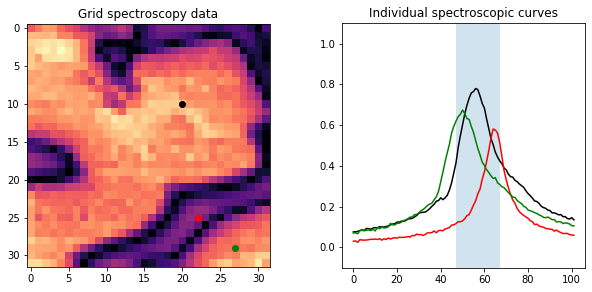

In [0]:
# choose slice
slice_number = 57
# size of window for averaging
spectral_window = 10
# select cooordinates for individual spectroscopic curves
pos = [
       [10, 20], 
       [25, 22], 
       [29, 27],
]
# plot
gprutils.plot_raw_data(R_true, slice_number, pos, spectral_window, norm=True)

Now we corrupt data by removing certain percentage of the observations (i.e. removing the entire spectroscopic curves from random xy locations):

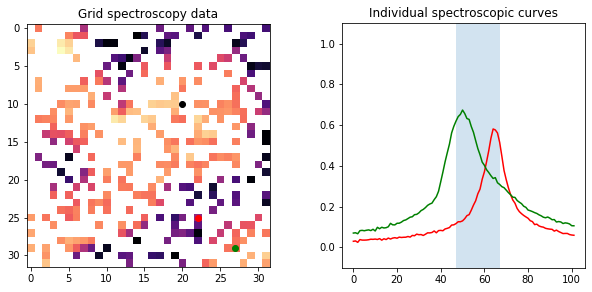

In [0]:
remove_obs = 0.7 # remove 70 % of the data

# Store "true" grid indices before removing parts of the data
X_true = gprutils.get_grid_indices(R_true)
# Remove observations and plot the new "corrupted" data
X, R = gprutils.corrupt_data_xy(X_true, R_true, prob=remove_obs)
gprutils.plot_raw_data(R, slice_number, pos, spectral_window, norm=True)

We now run GP regression on the corrupted data to reconstruct the original signal:

(This may take some some on older GPUs such as Tesla K80)

In [0]:
lengthscale_ = [[1., 1., 1.], [20., 20., 20.]]

reconstr = gpr.reconstructor(
    X, R, X_true, kernel='Matern52', lengthscale=lengthscale_, 
    indpoints=1000, learning_rate=0.1, iterations=500, 
    use_gpu=True, verbose=True
)
mean, sd, hyperparams = reconstr.run()

# of inducing points for GP regression: 1004
Model training...
iter: 0 ... loss: 34727.872 ... amp: 8.6959 ... length: [ 8.3244 17.3963  3.7983] ... noise: 0.9048374 ...
iter: 100 ... loss: -51434.4585 ... amp: 0.1981 ... length: [ 8.1855 18.2577 19.3444] ... noise: 0.0018303 ...
average time per iteration: 0.2206 s
iter: 200 ... loss: -61831.3579 ... amp: 0.0124 ... length: [ 3.248   5.24   19.5679] ... noise: 0.0006585 ...
iter: 300 ... loss: -62216.8244 ... amp: 0.0115 ... length: [ 3.2238  4.9841 19.3812] ... noise: 0.0006291 ...
iter: 400 ... loss: -62278.6504 ... amp: 0.0102 ... length: [ 3.1328  4.7968 18.7803] ... noise: 0.0006232 ...
iter: 499 ... loss: -62381.779 ... amp: 0.0068 ... length: [ 2.8147  4.2695 16.7399] ... noise: 0.0006123 ...
training completed in 109.36 s
Final parameter values:
 amp: 0.0068, lengthscale: [ 2.8147  4.2695 16.7399], noise: 0.0006123
Calculating predictive mean and variance... Done


Plot the evolution of hyperparameters during the training:

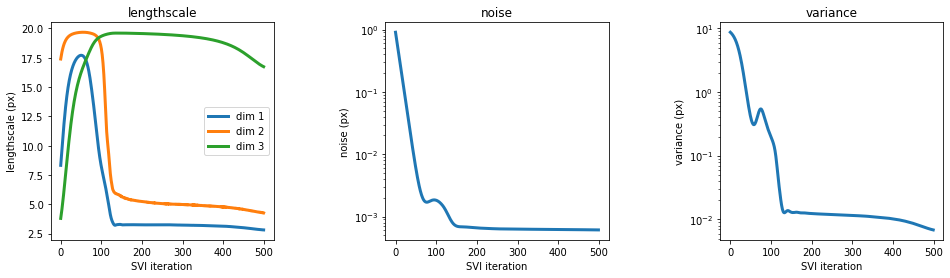

In [0]:
gprutils.plot_kernel_hyperparams(hyperparams)

Plot the evolution of inducing points:

(may take up to ~1 minute)

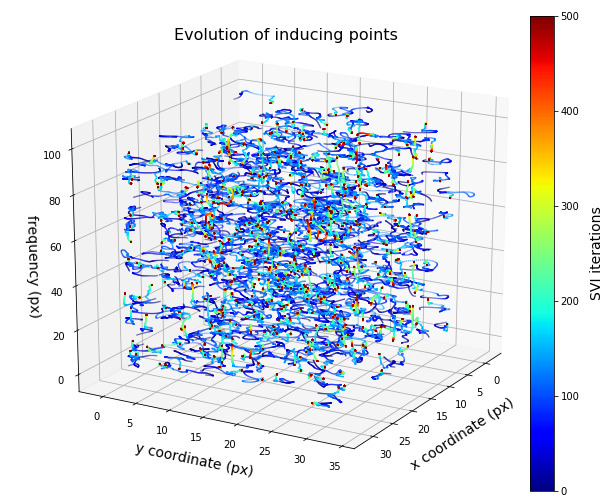

In [0]:
gprutils.plot_inducing_points(hyperparams, slice_step=2)

Plot the results:

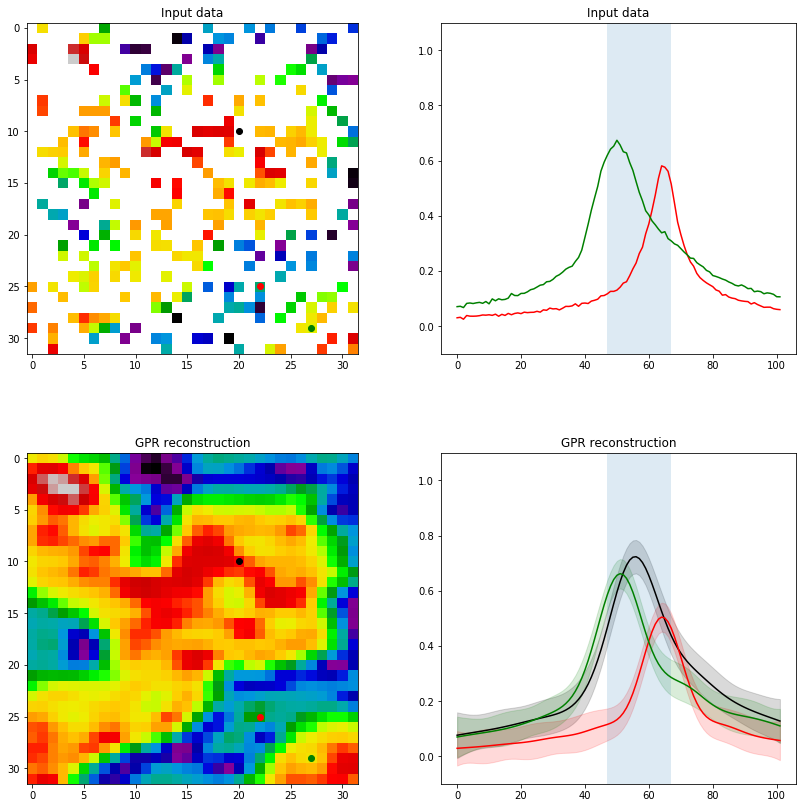

In [0]:
gprutils.plot_reconstructed_data3d(R, mean, sd, slice_number, pos, spectral_window)

Looks like even with ~70 % of observations removed we were able to reconstruct the original signal pretty accurately!